In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load and preprocess data
data = pd.read_csv('XIJ_combined_output.csv')
data


,Time,Open,High,Low,Last,Change,%Chg,Volume
0,2023-02-01 10:00:00,1484.8,1485.4,1484.8,1485.4,0.6,+0.04%,0.0
1,2023-02-01 10:01:00,1485.8,1485.8,1485.8,1485.8,0.4,+0.03%,0.0
2,2023-02-01 10:02:00,1485.8,1487.4,1485.8,1487.4,1.6,+0.11%,0.0
3,2023-02-01 10:03:00,1487.6,1487.6,1487.0,1487.0,-0.4,-0.03%,0.0
4,2023-02-01 10:04:00,1487.2,1487.3,1487.2,1487.3,0.3,+0.02%,0.0
...,...,...,...,...,...,...,...,...
176590,2024-11-29 16:14:00,2866.9,2866.9,2866.9,2866.9,0.0,0.00%,0.0
176591,2024-11-29 16:15:00,2866.9,2866.9,2866.9,2866.9,0.0,0.00%,0.0
176592,2024-11-29 16:16:00,2866.9,2866.9,2866.9,2866.9,0.0,0.00%,0.0
176593,2024-11-29 16:17:00,2866.9,2866.9,2866.9,2866.9,0.0,0.00%,0.0


In [ ]:
# Standardize column names and select desired features
actual_columns = [col.lower() for col in data.columns]
features_X = ['open', 'high', 'low']  # Features for X
target_y = 'last'  # Target column for y
print(actual_columns)
print(features_X)
print(target_y)

['time', 'open', 'high', 'low', 'last', 'change', '%chg', 'volume']
['open', 'high', 'low']
last


In [ ]:
# Ensure features exist in the dataset
features_X = [f for f in features_X if f in actual_columns]
features_X = [data.columns[actual_columns.index(f)] for f in features_X]  # Match case
target_y = data.columns[actual_columns.index(target_y)]  # Match case

data_X = data[features_X].values
data_y = data[[target_y]].values
print(data_X)
print(data_y)

[[1484.8 1485.4 1484.8]
 [1485.8 1485.8 1485.8]
 [1485.8 1487.4 1485.8]
 ...
 [2866.9 2866.9 2866.9]
 [2866.9 2866.9 2866.9]
 [2866.9 2866.9 2866.9]]
[[1485.4]
 [1485.8]
 [1487.4]
 ...
 [2866.9]
 [2866.9]
 [2866.9]]


In [ ]:
# Create sequences for LSTM
def create_sequences(data_X, data_y, seq_length):
    X, y = [], []
    for i in range(len(data_X) - seq_length):
        X.append(data_X[i:i + seq_length])  # Sequence of features
        y.append(data_y[i + seq_length])   # Corresponding target value
    return np.array(X), np.array(y)

sequence_length = 360  # Define sequence length
X, y = create_sequences(data_X, data_y, sequence_length)

print(f"Length of X is {len(X)}")
print(f"Length of Y is {len(y)}")
print(f"Value of X is \n{X}")
print(f"Value of Y is \n{y}")

Length of X is 176235
Length of Y is 176235
Value of X is 
[[[1484.8 1485.4 1484.8]
  [1485.8 1485.8 1485.8]
  [1485.8 1487.4 1485.8]
  ...
  [1480.7 1480.7 1480.7]
  [1480.8 1480.8 1480.6]
  [1480.5 1480.5 1479.5]]

 [[1485.8 1485.8 1485.8]
  [1485.8 1487.4 1485.8]
  [1487.6 1487.6 1487. ]
  ...
  [1480.8 1480.8 1480.6]
  [1480.5 1480.5 1479.5]
  [1479.2 1479.2 1479.2]]

 [[1485.8 1487.4 1485.8]
  [1487.6 1487.6 1487. ]
  [1487.2 1487.3 1487.2]
  ...
  [1480.5 1480.5 1479.5]
  [1479.2 1479.2 1479.2]
  [1479.2 1479.2 1479.2]]

 ...

 [[2847.8 2848.8 2847.8]
  [2848.4 2848.7 2848.4]
  [2848.4 2852.4 2848.4]
  ...
  [2866.9 2866.9 2866.9]
  [2866.9 2866.9 2866.9]
  [2866.9 2866.9 2866.9]]

 [[2848.4 2848.7 2848.4]
  [2848.4 2852.4 2848.4]
  [2852.1 2852.1 2852.1]
  ...
  [2866.9 2866.9 2866.9]
  [2866.9 2866.9 2866.9]
  [2866.9 2866.9 2866.9]]

 [[2848.4 2852.4 2848.4]
  [2852.1 2852.1 2852.1]
  [2854.3 2854.3 2853.3]
  ...
  [2866.9 2866.9 2866.9]
  [2866.9 2866.9 2866.9]
  [2866.9 2866

In [ ]:
# Define split ratios
train_ratio = 0.6  # 60% for training
test_ratio = 0.3   # 30% for testing
val_ratio = 0.1    # 10% for validation

# Calculate the sizes
train_size = int(len(X) * train_ratio)
test_size = int(len(X) * test_ratio)
val_size = len(X) - train_size - test_size

# Perform the splits
X_train, X_temp = X[:train_size], X[train_size:]
y_train, y_temp = y[:train_size], y[train_size:]

X_val, X_test = X_temp[:val_size], X_temp[val_size:]
y_val, y_test = y_temp[:val_size], y_temp[val_size:]

# Check the lengths
print(f"Length of X_train is {len(X_train)}")
print(f"Length of X_val is {len(X_val)}")
print(f"Length of X_test is {len(X_test)}")
print(f"Length of y_train is {len(y_train)}")
print(f"Length of y_val is {len(y_val)}")
print(f"Length of y_test is {len(y_test)}")

# Optionally print the data (comment out for large datasets)
# print("X_train:", X_train)
# print("X_val:", X_val)
# print("X_test:", X_test)
# print("y_train:", y_train)
# print("y_val:", y_val)
# print("y_test:", y_test)


Length of X_train is 105741
Length of X_val is 17624
Length of X_test is 52870
Length of y_train is 105741
Length of y_val is 17624
Length of y_test is 52870


In [ ]:
# Scale training data
scaler_X = MinMaxScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])  # Flatten for scaling
X_train_scaled = scaler_X.fit_transform(X_train_flat).reshape(X_train.shape)  # Scale and reshape

# Scale testing data
X_test_flat = X_test.reshape(-1, X_test.shape[-1])  # Flatten for scaling
X_test_scaled = scaler_X.transform(X_test_flat).reshape(X_test.shape)  # Scale and reshape

# Scale validation data
X_val_flat = X_val.reshape(-1, X_val.shape[-1])  # Flatten for scaling
X_val_scaled = scaler_X.transform(X_val_flat).reshape(X_val.shape)  # Scale and reshape

# Scale target (y) data
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)  # Scale target (train)
y_test_scaled = scaler_y.transform(y_test)       # Scale target (test)
y_val_scaled = scaler_y.transform(y_val)         # Scale target (validation)

# Print lengths of scaled data
print(f"Length of X train scaled is {len(X_train_scaled)}")
print(f"Length of X test scaled is {len(X_test_scaled)}")
print(f"Length of X val scaled is {len(X_val_scaled)}")
print(f"Length of y train scaled is {len(y_train_scaled)}")
print(f"Length of y test scaled is {len(y_test_scaled)}")
print(f"Length of y val scaled is {len(y_val_scaled)}")

#Print values of data
print(f"Value of X train scaled is \n{X_train_scaled}")
print(f"Value of X test scaled is \n{X_test_scaled}")
print(f"Value of X val scaled is \n{X_val_scaled}")
print(f"Value of y train scaled is \n{y_train_scaled}")
print(f"Value of y test scaled is \n{y_test_scaled}")
print(f"Value of y val scaled is \n{y_val_scaled}")


Length of X train scaled is 105741
Length of X test scaled is 52870
Length of X val scaled is 17624
Length of y train scaled is 105741
Length of y test scaled is 52870
Length of y val scaled is 17624
Value of X train scaled is 
[[[0.07197358 0.07107004 0.07199818]
  [0.0731124  0.07152635 0.07313739]
  [0.0731124  0.07335159 0.07313739]
  ...
  [0.06730441 0.06570842 0.06732741]
  [0.06741829 0.0658225  0.06721349]
  [0.06707664 0.06548026 0.06596036]]

 [[0.0731124  0.07152635 0.07313739]
  [0.0731124  0.07335159 0.07313739]
  [0.07516228 0.07357974 0.07450444]
  ...
  [0.06741829 0.0658225  0.06721349]
  [0.06707664 0.06548026 0.06596036]
  [0.06559617 0.06399726 0.06561859]]

 [[0.0731124  0.07335159 0.07313739]
  [0.07516228 0.07357974 0.07450444]
  [0.07470675 0.07323751 0.07473229]
  ...
  [0.06707664 0.06548026 0.06596036]
  [0.06559617 0.06399726 0.06561859]
  [0.06559617 0.06399726 0.06561859]]

 ...

 [[0.98804236 0.9880219  0.98792436]
  [0.98804236 0.98893452 0.98838004]
  

In [ ]:
# Build the LSTM model with Dropout
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),

    LSTM(32, return_sequences=False),

    Dense(16, activation='relu'),

    Dense(1)  # Predicting the target ('last')
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 360, 32)             │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,473 (52.63 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
epochs = 20
batch_size = 32
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=epochs, batch_size=batch_size, verbose=1
)

Epoch 1/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - loss: 2.9277e-06 - val_loss: 4.5797e-06
Epoch 2/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 2.6423e-06 - val_loss: 4.2378e-06
Epoch 3/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 2.7264e-06 - val_loss: 2.1706e-06
Epoch 4/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 69s 21ms/step - loss: 2.9375e-06 - val_loss: 8.6226e-06
Epoch 5/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 2.7527e-06 - val_loss: 4.5141e-06
Epoch 6/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 2.5830e-06 - val_loss: 1.8700e-05
Epoch 7/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 2.7007e-06 - val_loss: 1.8586e-06
Epoch 8/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 3.1073e-06 - val_loss: 5.5329e-06
Epoch 9/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 2.7799e-06 - val_loss: 1.7696e-06
Epoch 10/20
3305/3305 ━━━━━━━━━━━━━━━━━━━━ 68s 21ms/step - loss: 2.6834e-06 - val_loss: 2.6581e-05
Epoch 11/20
3305/33

In [ ]:
# Make predictions
predictions_scaled = model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled)  # Convert back to original scale
y_test_actual = scaler_y.inverse_transform(y_test_scaled)     # Convert test y back to original scale
length_prdiction = len(predictions)
length_actual = len(y_test_actual)
print(f"Length of predictions is {length_prdiction}")
print(f"Length of y_test_actual is {length_actual}")

print(f"Value of predictions is \n{predictions}")
print(f"Value of y_test_actual is \n{y_test_actual}")


1653/1653 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step
Length of predictions is 52870
Length of y_test_actual is 52870
Value of predictions is 
[[2266.5452]
 [2266.2642]
 [2266.4683]
 ...
 [2796.3584]
 [2796.4219]
 [2796.468 ]]
Value of y_test_actual is 
[[2268.8]
 [2269.1]
 [2269.4]
 ...
 [2866.9]
 [2866.9]
 [2866.9]]


In [ ]:
# Calculate metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, predictions)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"MAPE: {mape}%")
print(f"R2 Score: {r2}")


MAE: 25.433471728635684
MSE: 1474.5977800828462
MAPE: 0.9474899703223334%
R2 Score: 0.9636597512865284


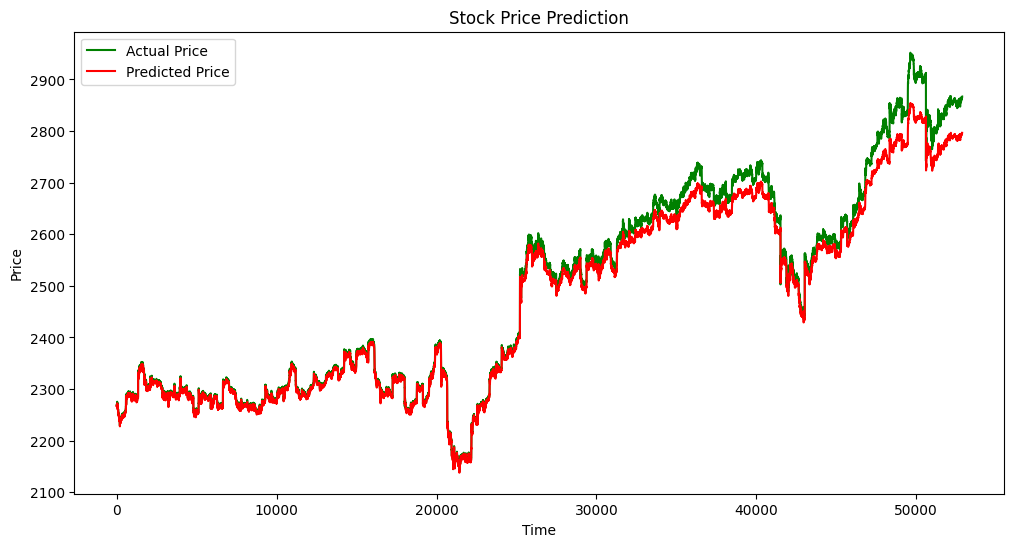

In [ ]:
# Plot the results
time_range = range(len(y_test_actual))
plt.figure(figsize=(12, 6))
plt.plot(time_range, y_test_actual, color='green', label='Actual Price')
plt.plot(time_range, predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

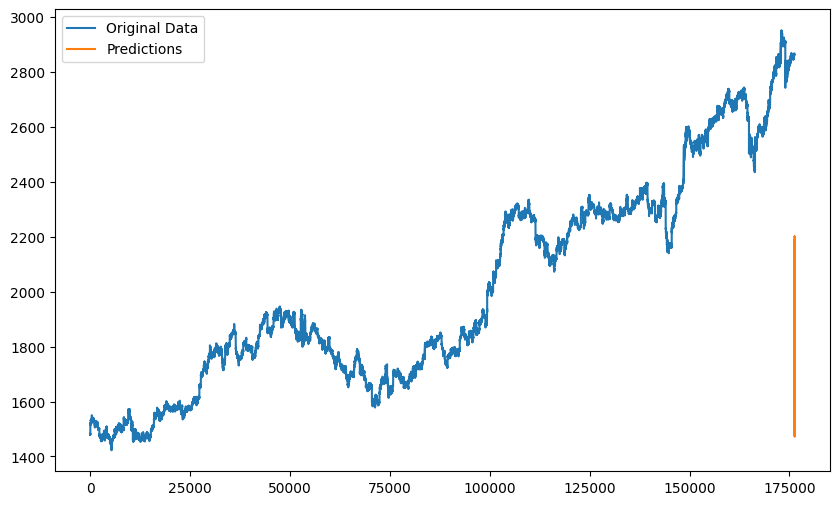

In [ ]:
# Parameters
lookback = 10  # Number of previous timesteps to consider
future_steps = 100  # Predict up to December 1, 2024

# Recursive Prediction
def recursive_predict(model, X_seed, lookback, future_steps, scaler_y):
    recursive_predictions = []
    input_seq = np.array(X_seed[-lookback:])  # Preserve initial sequence shape

    for _ in range(future_steps):
        # Reshape input for prediction
        input_array = input_seq[-lookback:].reshape(1, lookback, -1)

        # Predict next step
        pred = model.predict(input_array, verbose=0)
        pred_rescaled = scaler_y.inverse_transform(pred)  # Rescale to original scale
        recursive_predictions.append(pred_rescaled[0, 0])  # Append prediction

        # Append prediction and preserve shape
        next_step = np.zeros_like(input_seq[-1])  # Match dimensions
        next_step[:, 0] = pred[0, 0]  # Update predicted feature
        input_seq = np.concatenate([input_seq, next_step[np.newaxis, :, :]])[-lookback:]  # Keep shape consistent

    return recursive_predictions

# Generate future predictions
seed = X_val_scaled[-lookback:]
recursive_predictions = recursive_predict(model, seed, lookback, future_steps, scaler_y)

# Extend the original data with predictions for continuity
y_flat = y.flatten()  # Flatten 'y' to 1D if it's 2D
recursive_predictions = np.array(recursive_predictions).flatten()  # Ensure predictions are 1D

# Adjust x-axis for actual and predictions
x_actual = np.arange(len(y_flat))
x_pred = np.arange(len(y_flat), len(y_flat) + future_steps)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x_actual, y_flat, label='Original Data')  # Plot original data
plt.plot(x_pred, recursive_predictions, label='Predictions')  # Plot predictions separately
plt.legend()
plt.show()


# New Section